In [1]:
import numpy as np
import matplotlib.pyplot as plt

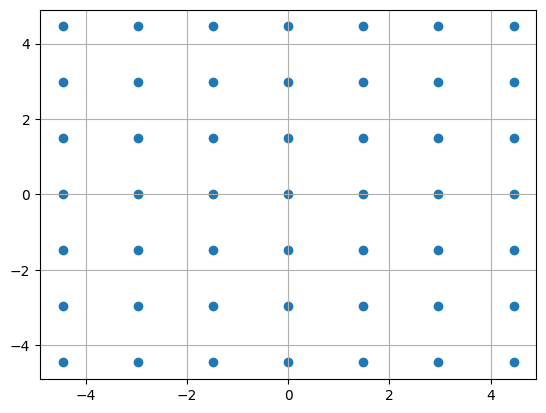

In [9]:
# structure definition
period_x = 0.357
period_y = 0.357

# Incidence wave
wavelength = 0.530
k0 = np.pi*2 / wavelength

# Harmonics and mode number

num_harmonics_x = 3  # num of x harmonics -num to +num
num_harmonics_y = 3  # num of y harmonics -num to +num

num_modes_x = num_harmonics_x*2+1  # num of x modes
num_modes_y = num_harmonics_y*2+1  # num of y modes

num_modes = num_modes_x * num_modes_y  # total modes


def ind2mode(id):
    id = id % num_modes
    ix = id % num_modes_x
    iy = id // num_modes_x
    mx = ix - num_harmonics_x
    my = iy - num_harmonics_y
    return mx, my

gx = wavelength / period_x
gy = wavelength / period_y

mx, my = ind2mode(np.arange(num_modes))

k0x = np.sin()

kx = mx * gx + k0x
ky = my * gy + k0y
plt.scatter(kx, ky)
plt.grid()
plt.show()
